# Lab Assignment 1: Data Cleaning

In [42]:
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit

import re
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go

from plotly.graph_objs import Scatter, Figure, Layout

init_notebook_mode(connected=True)

#!pip install datacleaner
#def natural_sort(l): 
 #   convert = lambda text: int(text) if text.isdigit() else text.lower() 
 #   alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
 #   return sorted(l, key = alphanum_key)

# Loading and sorting road data

In [6]:
path ='D:\Jupyter_File\Advanced_Discrete_Cleaning\_roads2.csv'

df = pd.read_csv(path,index_col=None, header=0)

df_clean_0 = df.drop_duplicates(subset=['lon','lat','chainage'], keep=False)

print('Total data before drop duplicates:' ,len(df),'Data')
print('Total data after drop duplicates:' ,len(df_clean_0),'Data')

Total data before drop duplicates: 52210 Data
Total data after drop duplicates: 51706 Data


#  Delete roads with length 1

In [7]:
road_indices = df_clean_0['road'].value_counts().sort_index()
road_indices[(road_indices < 2)]

N125    1
N126    1
R316    1
Name: road, dtype: int64

In [8]:
#Find data that have N,R,Z road name
df_N_road = df_clean_0[df_clean_0['road'].str.match('N',case=True, as_indexer=True)]
df_R_road = df_clean_0[df_clean_0['road'].str.match('R',case=True, as_indexer=True)]
df_Z_road = df_clean_0[df_clean_0['road'].str.match('Z',case=True, as_indexer=True)]

# Sort the dataframe based on values
df_N_road.sort_values(by=['road'])
df_R_road.sort_values(by=['road'])
df_Z_road.sort_values(by=['road'])

# Show summary of information data
print('Total N Roads Data:', len(df_N_road))
print('Total R Roads Data:', len(df_R_road))
print('Total Z Roads Data:', len(df_Z_road))
print('Total All Roads Data:', len(df_N_road)+len(df_R_road)+len(df_Z_road))

Total N Roads Data: 9722
Total R Roads Data: 9831
Total Z Roads Data: 32153
Total All Roads Data: 51706


In [9]:
# Count the number of data based on the road name ('road')
N_road_data_counts = df_N_road['road'].value_counts().sort_index()
R_road_data_counts = df_R_road['road'].value_counts().sort_index()
Z_road_data_counts = df_Z_road['road'].value_counts().sort_index()

# Count the how many road are there
Unique_N_road = len(N_road_data_counts)
Unique_R_road = len(R_road_data_counts)
Unique_Z_road = len(Z_road_data_counts)

print('There are','[', Unique_N_road,']', 'N roads')
print('There are','[', Unique_R_road,']', 'R roads')
print('There are','[', Unique_Z_road,']', 'Z roads')

There are [ 95 ] N roads
There are [ 125 ] R roads
There are [ 656 ] Z roads


# Loop for detecting errative Lat and Lon values

In [10]:
# create indices matrix
road_indices = []
road_indices.append(N_road_data_counts)
road_indices.append(R_road_data_counts)
road_indices.append(Z_road_data_counts)
road_indices = [y for x in road_indices for y in x]

# set filtering variables
Win       = 20  # size of moving average window
threshold = 3   # maximum allowed strandard deviation difference
maxIter   = 4   # maximum amount of iteration steps allowed per road

# create empty lists
ErLat = []
ErLon = []

# starting endpoint
ep = 0

# define list of errors
outliers = []

# time calculation time
start = timeit.default_timer()

# loop for al N roads
for i in range(len(road_indices)):
    
    # startpoint
    sp = ep
    ep = ep + road_indices[i]
    
    # selecting data
    roadFrame = df_clean_0[sp:ep]
    
    # reset check value
    check = 0
    
    # continuously solving more points
    while (check < maxIter ): # maximum 4 iterations allowed

        # rolling standard deviation of lat and lon
        stdLat = roadFrame['lat'].rolling(window=Win,min_periods=1,center=False).std()
        stdLon = roadFrame['lon'].rolling(window=Win,min_periods=1,center=False).std()

        # moving average
        meanLat = roadFrame['lat'].rolling(window=Win,min_periods=1,center=False).mean()
        meanLon = roadFrame['lon'].rolling(window=Win,min_periods=1,center=False).mean()

        # determine correct values (Boolean)
        ErrorLat = abs(roadFrame['lat'] - meanLat) > threshold * stdLat
        ErrorLon = abs(roadFrame['lon'] - meanLon) > threshold * stdLon

        # determine if dataset is correct or not
        if (sum(ErrorLat) + sum(ErrorLon) == 0): # end while loop 
            check = 100
        else:
            # errorindices
            ErrorIndexLat = roadFrame[ErrorLat].index
            ErrorIndexLon = roadFrame[ErrorLon].index
            
            # append error indices to list
            ErLat.append(ErrorIndexLat)
            ErLon.append(ErrorIndexLon)
            
            # select new dataframe without errative values for next iteration
            roadFrame = roadFrame[(~ErrorLat) & (~ErrorLon)]
            
            # set check counter
            check = check + 1
    
stop = timeit.default_timer()

print(stop-start)

8.010396444444444


# Replace errative values with NaN

In [43]:
# create complete list with errors
ErLonList = [y for x in ErLon for y in x]
ErLatList = [y for x in ErLat for y in x]
print('amount of errative longitude values found: ', len(ErLonList))
print('amount of errative lattitude values found: ', len(ErLatList))

# replace errative parts with NaN
df_clean_0.loc[ErLonList,'lon'] = float('NaN')
df_clean_0.loc[ErLatList,'lat'] = float('NaN')

amount of errative longitude values found:  837
amount of errative lattitude values found:  878


C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [44]:
# plot filtered data
#Find data that have N,R,Z road name
df_N_road = df_clean_0[df_clean_0['road'].str.match('N',case=True, as_indexer=True)]
df_R_road = df_clean_0[df_clean_0['road'].str.match('R',case=True, as_indexer=True)]
df_Z_road = df_clean_0[df_clean_0['road'].str.match('Z',case=True, as_indexer=True)]

# Sort the dataframe based on values
df_N_road.sort_values(by=['road'])
df_R_road.sort_values(by=['road'])
df_Z_road.sort_values(by=['road'])


# plot N roads
#df_N_road.plot.scatter(x='lon',y='lat')

iplot([Scatter(x=df_N_road['lat'], y=df_N_road['lon'], mode='markers')])

In [45]:
# plot filtered data
#df_R_road.plot.scatter(x='lon',y='lat')
iplot([Scatter(x=df_R_road['lat'], y=df_R_road['lon'], mode='markers')])

In [50]:
# plot filtered data
#df_Z_road.plot.scatter(x='lon',y='lat')
iplot([Scatter(x=df_Z_road['lat'], y=df_Z_road['lon'], mode='markers')])

# Save data back to CSV (not finished)

In [7]:
dk = pd.DataFrame()
dk = dk.append(df_N_road['road'].value_counts()>100)
dk = dk.transpose()
dk = dk.reset_index()
dk = dk.rename(index=str, columns={"road": "N road > 100","index":"road"})
dk.head()


road  N road > 100
0    N1           1.0
1  N101           0.0
2  N102           1.0
3  N103           0.0
4  N104           1.0

In [84]:
outliers = []

In [87]:
errors = 3, 4, 5
outliers.append(errors)
print(outliers)

[(3, 4, 5), (3, 4, 5), (3, 4, 5)]


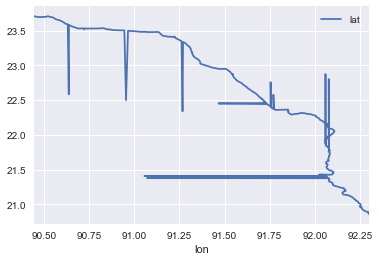

In [106]:
# define start and endpositions
startpoint = 0
endpoint  = 1338
threshold = 4 # amounts of allowed sigma deviation from mean
window    = 20 # size of window for moving average/mean




# create dataframe and plot original data
testframe = df_N_road[startpoint:endpoint]


testframe.plot(x = 'lon', y = 'lat')


In [108]:
# create moving average  matrices
RolMeanLat = pd.rolling_mean(testframe['lat'], window, min_periods = 1)
RolMeanLon = pd.rolling_mean(testframe['lon'], window, min_periods = 1)

# create moving standard deviation matrices
RolStdLat = pd.rolling_std(testframe['lat'], window, min_periods = 1)
RolStdLon = pd.rolling_std(testframe['lon'], window, min_periods = 1)


# boolean for correct values for lon and lat
LatCorrect = abs(testframe['lat'] - RolMeanLat) > threshold * RolStdLat
LonCorrect = abs(testframe['lon'] - RolMeanLon) > threshold * RolStdLon

print(sum(LatCorrect)+sum(LonCorrect))

print(testframe[LatCorrect]['lat'])
print(testframe.loc[LatCorrect,'lat'])

testframe[LatCorrect]['lat'] = float('NaN')
testframe[LonCorrect]['lon'] = float('NaN')


print(testframe[LatCorrect]['lat'])
print(testframe.loc[LatCorrect,'lat'])

# plot correct values
#testframe[LatCorrect & LonCorrect].plot(x = 'lon', y = 'lat')




C:\Users\Nout\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).mean()
  
C:\Users\Nout\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Nout\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).std()
  
C:\Users\Nout\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(wind

9
69     22.583750
154    22.499527
233    22.339055
553    22.758417
792    22.874916
817    22.802917
Name: lat, dtype: float64
69     22.583750
154    22.499527
233    22.339055
553    22.758417
792    22.874916
817    22.802917
Name: lat, dtype: float64


C:\Users\Nout\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Nout\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


69     22.583750
154    22.499527
233    22.339055
553    22.758417
792    22.874916
817    22.802917
Name: lat, dtype: float64
69     22.583750
154    22.499527
233    22.339055
553    22.758417
792    22.874916
817    22.802917
Name: lat, dtype: float64


C:\Users\Nout\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).mean()
  
C:\Users\Nout\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).mean()
  import sys
C:\Users\Nout\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).std()
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Nout\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_period

1338
1328


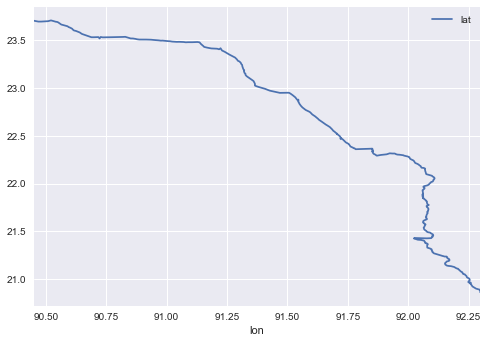

In [68]:
# repeat operation with cleaned data

newtestframe = testframe[LatCorrect & LonCorrect]

# create moving average  matrices
RolMeanLat = pd.rolling_mean(newtestframe['lat'], window, min_periods = 1)
RolMeanLon = pd.rolling_mean(newtestframe['lon'], window, min_periods = 1)

# create moving standard deviation matrices
RolStdLat = pd.rolling_std(newtestframe['lat'], window, min_periods = 1)
RolStdLon = pd.rolling_std(newtestframe['lon'], window, min_periods = 1)

# boolean for correct values for lon and lat
LatCorrect = abs(newtestframe['lat'] - RolMeanLat) < threshold * RolStdLat
LonCorrect = abs(newtestframe['lon'] - RolMeanLon) < threshold * RolStdLon


# plot correct values
newtestframe[LatCorrect & LonCorrect].plot(x = 'lon', y = 'lat')

print(len(testframe))
print(len(newtestframe))

   road  chainage      lrp        lat        lon     type             name
65   N1    25.629   LRP026  23.596000  90.624666   KmPost  Km post missing
66   N1    25.639  LRP026a  23.595944  90.624694  Culvert      Box culvert
67   N1    26.313  LRP026b  23.591750  90.629333  Culvert      Box culvert
68   N1    26.629   LRP027  23.589611  90.631388   KmPost  Km post missing
69   N1    27.503  LRP027a  22.583750  90.636944   Bridge     Bridge start


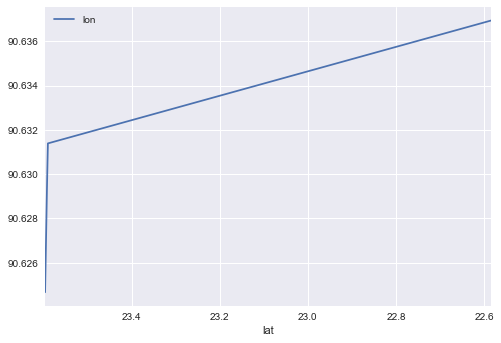

In [20]:
testframe[65:70].plot(x='lat', y = 'lon')
print(testframe[65:70])

## N roads 

In [214]:
def mad_based_outlier(points, thresh=2):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh 

In [216]:
mad_based_outlier(df_N_road[0:100]['lat'])
# Check per 100, but it will be considered as outliers if the "True" data have no series of "True" before and after that. 
# "True series should be greater than 5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [10]:
type((df_N_road[0:30]['lat']))
df_N_road.mad()

chainage    101.300504
lat           0.912602
lon           0.972645
dtype: float64

In [9]:
initial = 0

for a in range(0, Unique_N_road):
    
    N_road_lat = df_N_road[initial:N_road_data_counts[a]+initial]['lat']
    
    for b in  N_road_lat:
        
        #median = N_road_lat.median()
        #absolute = abs(b-median)
        
        #mad = np.median(absolute)
    
        #print (mad)
        #df_N_road['MAD'] = mad
        
        df_N_road.mad()
    initial = initial+N_road_data_counts[a]

df_N_road.head()

road  chainage     lrp        lat        lon       type  \
0   N1     0.000    LRPS  23.706028  90.443333     Others   
1   N1     0.814   LRPSa  23.702917  90.450417    Culvert   
2   N1     0.822   LRPSb  23.702778  90.450472  CrossRoad   
3   N1     1.000  LRP001  23.702139  90.451972     KmPost   
4   N1     2.000  LRP002  23.697889  90.460583     KmPost   

                                                name  
0  Start of Road  after Jatrabari Flyover infront...  
1                                        Box Culvert  
2                            Intersection with Z1101  
3                                    Km post missing  
4                                    Km post missing

## R roads 

## Z roads 